# Enter Dogs vs Cats

## Introduction

This notebook is a template for submission to a Kaggle competition: Dogs vs. Cats Redux: Kernels Edition

To start, we need to get the data ready. First, download the dataset using `kaggle cli`, and then arrange the data into the correct structure like the following:

```
utils/
    vgg16.py
    utils.py
redux.ipynb
data/
    redux/
        train/
            cat.123.jpg
            dog.2334.jpg
        test/
            432.jpg
            222.jpg
```

You can download the data files from the competition page [here](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) or you can download them from the command line using the [Kaggle CLI](https://github.com/floydwch/kaggle-cli).

```
pip install kaggle-cli
kg download -u yingchi.pei@gmail.com -p FL199473/kag -c dogs-vs-cats-redux-kernels-edition
```

In [1]:
# Verify the directory you are in 
%pwd

'/home/ubuntu/fastai-notes/deeplearning1/nbs'

In [2]:
# Create references to important directories 
import sys, os
current_dir = os.getcwd()
HOME_DIR = current_dir
DATA_HOME_DIR = current_dir + '/data/redux/'
print(current_dir, DATA_HOME_DIR)

/home/ubuntu/fastai-notes/deeplearning1/nbs /home/ubuntu/fastai-notes/deeplearning1/nbs/data/redux/


In [3]:
from utils import *
from vgg16 import Vgg16

%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


## Action Plan
1. Create validation and sample sets
2. Rearrange image files into their respective folders
3. Finetune and train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

## Create validation and sample set

Before moving on, we need to make sure that we have the `train.zip`, `test.zip` downloaded inside our DATA_HOME_DIR.
For example, inside the `/data` folder, my file structure looks like this:

```
yingchi nbs/data ‹master*› » tree -L 2
.
├── dogscats
│   ├── sample
│   ├── test1
│   ├── train
│   └── valid
└── redux
    ├── sample_submission.csv
    ├── test.zip
    └── train.zip
```

Then, unzip the `test.zip` and `train.zip` files.
```
unzip -q train.zip
```

In [4]:
# Create validation and sample directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/ubuntu/fastai-notes/deeplearning1/nbs/data/redux


In [5]:
# Move some training data into validation folder
%cd $DATA_HOME_DIR/train
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/'+shuf[i])

/home/ubuntu/fastai-notes/deeplearning1/nbs/data/redux/train


In [6]:
# Copy some training data into sample folder
from shutil import copyfile
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/'+shuf[i])

# Copy some validation data into sample validation folder
%cd $DATA_HOME_DIR/valid
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/'+shuf[i])

/home/ubuntu/fastai-notes/deeplearning1/nbs/data/redux/valid


In [7]:
# Create 'unknown' class for test set
%cd $DATA_HOME_DIR/sample/test/
%mkdir unknown
%mv *jpg unknown/

/home/ubuntu/fastai-notes/deeplearning1/nbs/data/redux/sample/test
mv: cannot stat '*jpg': No such file or directory


In [10]:
%cd $DATA_HOME_DIR/test/
%mv *.jpg unknown/
%cd $DATA_HOME_DIR/test/unknown/
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/test/'+shuf[i])

/home/ubuntu/fastai-notes/deeplearning1/nbs/data/redux/test
/home/ubuntu/fastai-notes/deeplearning1/nbs/data/redux/test/unknown


## Rearrange image files into /dogs /cats folders

In [9]:
%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat*.jpg cats/
%mv dog*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat*.jpg cats/
%mv dog*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat*.jpg cats/
%mv dog*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat*.jpg cats/
%mv dog*.jpg dogs/

/home/ubuntu/fastai-notes/deeplearning1/nbs/data/redux/sample/train
/home/ubuntu/fastai-notes/deeplearning1/nbs/data/redux/sample/valid
/home/ubuntu/fastai-notes/deeplearning1/nbs/data/redux/train
/home/ubuntu/fastai-notes/deeplearning1/nbs/data/redux/valid


## Finetuning and Training

In [14]:
%cd $DATA_HOME_DIR

# path = DATA_HOME_DIR + '/sample/'
path = DATA_HOME_DIR
test_path = path + '/test/' 
# Here. we use all the test data. You can also set to sample/test, 
# but make sure to copy some files to that folder first
results_path = path + '/results/'
train_path = path + '/train/'
valid_path = path + '/valid/'

/home/ubuntu/fastai-notes/deeplearning1/nbs/data/dogscats


In [15]:
vgg = Vgg16()
# Set constants. You can experiment with no_of_epochs to improve the model
batch_size = 64
no_of_epochs = 3

> What is batch_size?

> The batch_size on average only influences the speed of your learning, not the quality of learning. The batch_sizes also don't need to be powers of 2, although I understand that certain packages only allow powers of 2. You should try to get your batch_size the highest you can that still fits the memory of your GPU to get the maximum speed possible.

> Edit: I just found out that powers of 2 have some advantages with regards to vectorized operations in certain packages, so if it's close it might be faster to keep your batch_size in a power of 2.

> In the neural network terminology:
* one epoch = one forward pass and one backward pass of all the training examples
* batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
* number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).
Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

In [16]:
# Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)
vgg.finetune(batches)

vgg.model.optimizer.lr = 0.01

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [17]:
# Notice we are passing in the validation set to the fit() model
# For each epoch, we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print('Running epoch: %d' % epoch)
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print('Completed %s fit operations' % no_of_epochs)

Running epoch: 0
Epoch 1/1
23000/23000 [==============================] - 641s - loss: 0.3582 - acc: 0.9700 - val_loss: 0.2302 - val_acc: 0.9820
Running epoch: 1
Epoch 1/1
23000/23000 [==============================] - 645s - loss: 0.3489 - acc: 0.9745 - val_loss: 0.2523 - val_acc: 0.9825
Running epoch: 2
Epoch 1/1
23000/23000 [==============================] - 646s - loss: 0.3074 - acc: 0.9780 - val_loss: 0.3110 - val_acc: 0.9790
Completed 3 fit operations


## Generate Predictions

Let's use our new model to make predictions on the test dataset

In [18]:
batches, preds = vgg.test(test_path, batch_size=batch_size*2)
# test() is defined in utils.py, which uses prediction_generator() in keras

Found 12500 images belonging to 1 classes.


For every image, vgg.test() generates 2 probabilities, based on how we've ordered the cats/dogs directories. It looks like column 1 is cats and column 2 is dogs.

In [20]:
print(preds[:5])

filenames = batches.filenames
print(filenames[:5])

[[ 1.      0.    ]
 [ 0.0092  0.9908]
 [ 1.      0.    ]
 [ 1.      0.    ]
 [ 0.      1.    ]]
['unknown/9292.jpg', 'unknown/12026.jpg', 'unknown/9688.jpg', 'unknown/4392.jpg', 'unknown/779.jpg']


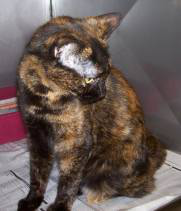

In [21]:
# You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [22]:
# Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Validate Predictions

Kera's fit() function shows us the value of the loss function, and the accuracy, after each epoch. The most important metrics for us to look at are for the validation set. 

> **Tip:** with our first model, we should try to overfit before we start worrying about how to reduce over-fitting. There is no point even thinking about regularization, data augmentation if you are sill under-fitting

As well as looking at the overall metrics, it's also a good idea to look at examples of:

1. a few correct labels at random
2. a few incorrect labels at random
3. the most correct labels of each class (i.e. with highest prob that are correct)
4. the most incorrect labels of each class (i.e. with highest prob that are incorrect)
5. the most uncertain labels (i.e. with prob close to 0.5)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [18]:
vgg.model.load_weights(results_path+latest_weights_filename)
val_batches, probs = vgg.test(valid_path, batch_size=batch_size)

Found 50 images belonging to 2 classes.


In [21]:
filenames = val_batches.filenames
expected_labels = val_batches.classes 
print(expected_labels[:3])

our_predictions = probs[:, 0] # we taking the 1st column, which is cat
our_labels = np.round(1 - our_predictions) # because the 1 -, now 0 is for cat
print(our_labels[:3])

[0 0 0]
[ 1.  0.  0.]


Now, let's see some examples of the above-mentioned cases:

In [22]:
from keras.preprocessing import image 

def plots_idx(idx, titles=None):
    """ Helper function to plot images by index in the validation set
    plots() is a helper function imported from utils.py
    """
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)

n_view = 4

Found 46 correct lables


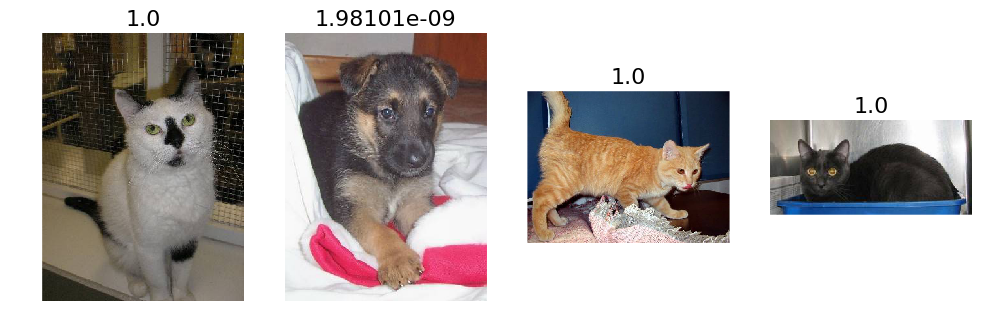

In [24]:
# 1. a few correct labels at random
correct = np.where(our_labels == expected_labels)[0]
print("Found %d correct lables" % len(correct))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Note that here the titles are a bit confusing. From the previous part:
```
our_predictions = probs[:, 0] # we taking the 1st column, which is cat
our_labels = np.round(1 - our_predictions) # because the 1 -, now 0 is for cat
```
所以因为之前的classes是vgg自己classify的，0代表cat，所以我们generate label的时候用1-1st column's prob， then round up。这里的titles是直接用了第一栏的probabilities。which is 1: cat.

Found 4 incorrect labels


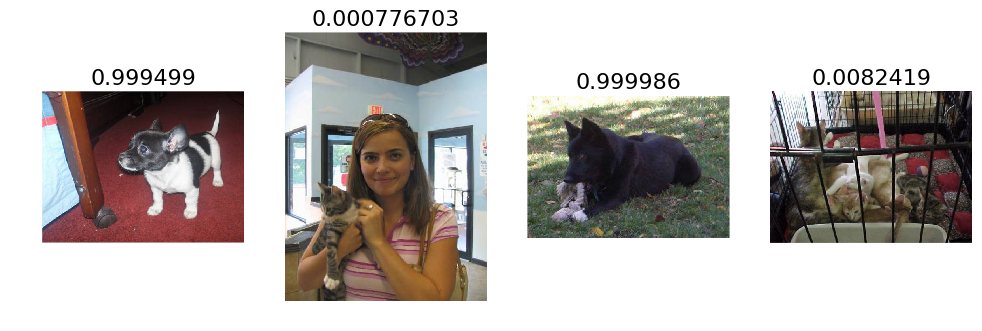

In [25]:
# 2. a few incorrect labels at random
incorrect = np.where(our_labels != expected_labels)[0]
print("Found %d incorrect labels" % len(incorrect))
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 23 confident correct cats labels


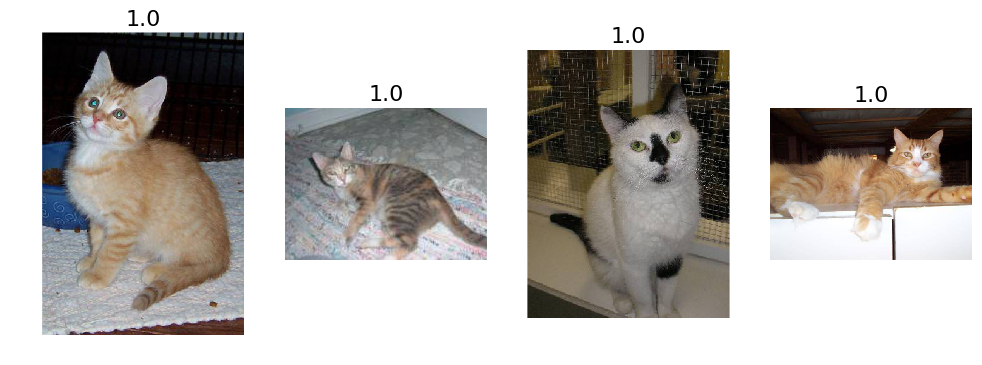

In [27]:
# 3a. classified as cats and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print("Found %d confident correct cats labels" % len(correct_cats))
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

In [28]:
# 3b. classified as dogs and are actually dogs
# correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]

Found 2 incorrect cats


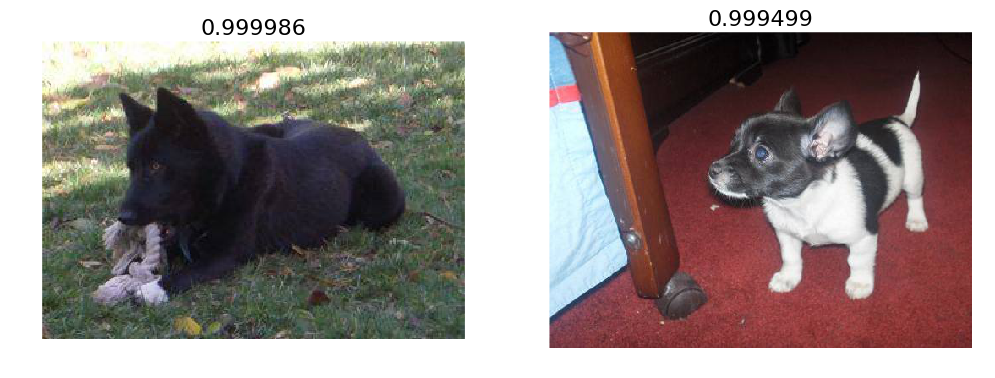

In [29]:
# 4a. classified as cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print("Found %d incorrect cats" % len(incorrect_cats))
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 2 incorrect dogs


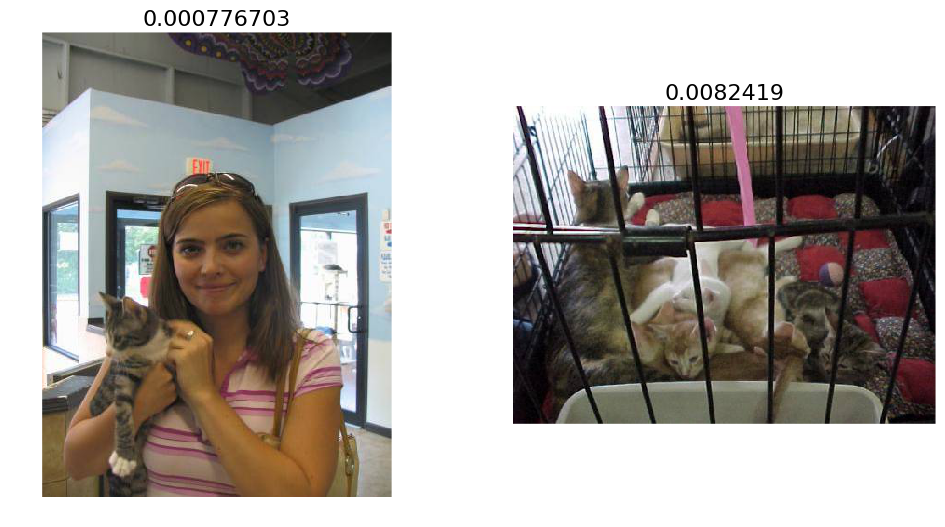

In [31]:
# 4b. the images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print("Found %d incorrect dogs" % len(incorrect_dogs))
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

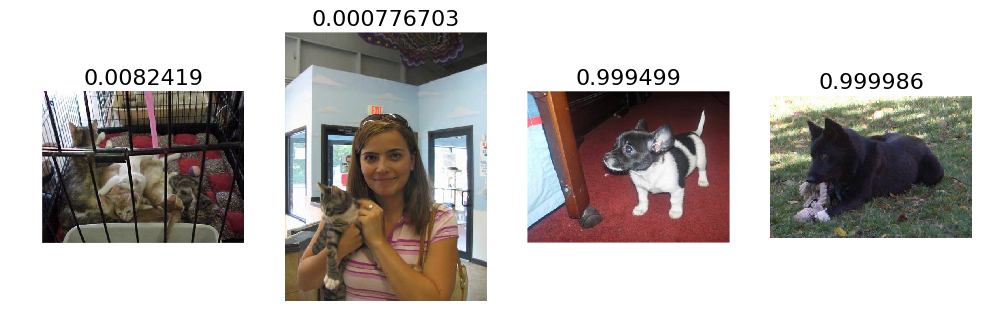

In [32]:
# 5. the most uncertain labels (i.e. those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

**Confusion matrix**

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

We can print out the confusion matrix, or show a graphical view.

[[23  2]
 [ 2 23]]


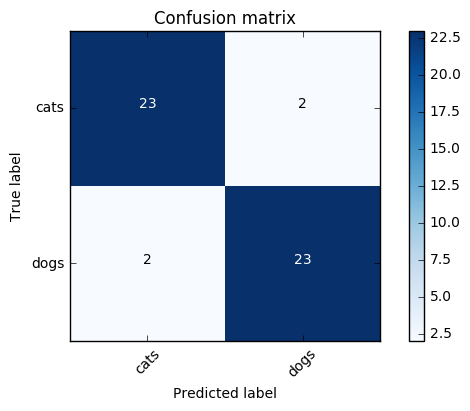

In [35]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Submit to Kaggle!

Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

In [ ]:
# Load our test predictions from file
pred = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

# Select the dog prediction column
isdog = preds[:, 1]
print("Raw Predictions: " + str(isdog[:5]))
print("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

Now, we need to care about another thing - [Log Loss](http://wiki.fast.ai/index.php/Log_Loss). Kaggle competition uses Log Loss to calculate your score, but Log Loss does not support probability values of 0 or 1. 

Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?

Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). See visualization below.

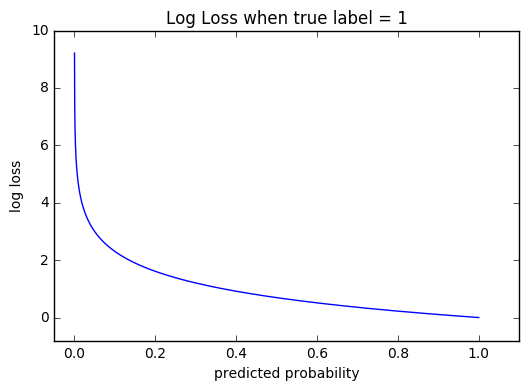

In [38]:
# Visualize Log Loss when True value = 1
# y-axis is log loss, x-axis is probabilty that label = 1
# As you can see Log Loss increases rapidly as we approach 0
# But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
# y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15) for i in range(1,10000,1)]
y = [log_loss([0],[[i*.0001,1-(i*.0001)]],eps=1e-15, labels=[1,0]) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

So to play it safe, we use a sneaky trick to round down our edge predictions
Swap all ones with .95 and all zeros with .05

In [ ]:
isdog = isdog.clip(min=0.05, max=0.95)
# numbers < 0.05 becomes 0.05

# Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

subm = np.stack([ids,isdog], axis=1)
subm[:5]

In [ ]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink('data/redux/'+submission_file_name)